<a href="https://colab.research.google.com/github/Akash-sahay/Medical-Research-Paper-simplifier/blob/main/Baseline_model_and_Conv1D_with_token_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check access to a GPU


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f6614ff4-1e6f-84fa-0917-62ccc1dfa75a)


Getting Data

In [ ]:

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 15.16 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:

# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:

# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
test_lines = get_lines(data_dir+"test.txt")
dev_lines = get_lines(data_dir+"dev.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines) # so we have this many lines in train lines. Each line is an element in the list.

210040

In [ ]:
def preprocess_data_in_structure(filename) :
  """
  Reads filename (a text file) and returns the lines of text as a list.
  """
  input_lines = get_lines(filename)
  abstract_lines =""
  abstract_samples = [] # we will return a list of dictionaries

  #looping through each line of the target file and separating the many different abstracts
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines =""
    elif line.isspace():
      abstract_split_line = abstract_lines.splitlines()

      #Now we loop through each line of a single abstract to see what goes on inside

      for abstract_line_number,abstract_lines in enumerate(abstract_split_line):
        #create an empty dictionary for each line
        line_data = {}
        #splitting the target text
        target_text_split = abstract_lines.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"]=target_text_split[1]
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_split_line)-1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line
  return abstract_samples



In [ ]:
train_samples = preprocess_data_in_structure(data_dir+"train.txt")
test_samples = preprocess_data_in_structure(data_dir+"test.txt")
dev_samples = preprocess_data_in_structure(data_dir+"dev.txt")

In [ ]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Secondary outcome measures included the Western Ontari

In [ ]:
import pandas as pd

In [ ]:
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
dev_df = pd.DataFrame(dev_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11


In [ ]:
len(train_df)

180040

In [ ]:
len(train_samples)

180040

In [ ]:
train_df.tail()

,target,text,line_number,total_lines
180035,RESULTS,For the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"For PAV , a significantly greater percentage o...",8,11
180037,RESULTS,Both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"Compared with standard statin monotherapy , th...",10,11
180039,CONCLUSIONS,( Plaque Regression With Cholesterol Absorptio...,11,11


In [ ]:
#lets check the distribution of labels
train_df["target"].value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

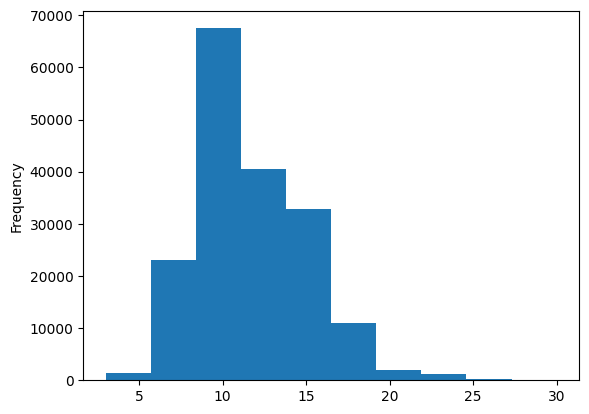

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
#getting text list
train_text_list = train_df["text"].to_list()


In [ ]:
train_text_list[:5]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .']

In [ ]:
len(train_text_list)

180040

MAKING NUMERIC LABELS BEFORE  MAKING NUMERIC DATA INPUTS

In [ ]:
#one hot encoded labels
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
train_labels_one_hot_encoded = ohe.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot_encoded = ohe.fit_transform(test_df["target"].to_numpy().reshape(-1,1))
dev_labels_one_hot_encoded = ohe.fit_transform(dev_df["target"].to_numpy().reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
train_labels_one_hot_encoded

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot_encoded)
tf.constant(test_labels_one_hot_encoded)
tf.constant(dev_labels_one_hot_encoded)

<tf.Tensor: shape=(30212, 5), dtype=float64, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [ ]:
#lets label encode the training labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_df["target"])
test_labels_encoded = le.fit_transform(test_df["target"])
dev_labels_encoded = le.fit_transform(dev_df["target"])

In [ ]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
count =0
for i in train_labels_encoded:
  if i==0:
    count+=1
print(count)
# so there are 21727 0 values.... the labels are 0, 1, 2, 3, 4

21727


In [ ]:
class_names = le.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

Modelling Experiment - Baseline (TF-IDF Multinomial Naive Bayes Classifier)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#create a pipeline
model_0 = Pipeline([
                    ("tfidf",TfidfVectorizer()),
                    ("clf",MultinomialNB())
])

#fit the pipeline to the training data
model_0.fit(train_df["text"],train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(dev_df["text"], dev_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(dev_df["text"])
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
baseline_preds.shape

(30212,)

In [ ]:
dev_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
dev_labels_encoded.shape

(30212,)

In [ ]:
# we can compare both these arrays to evaluate the predictions of our model. We can do this by downloading our helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-08-10 14:51:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-08-10 14:51:24 (19.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results


In [ ]:
#calculating baseline results
baseline_results = calculate_results(y_true=dev_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

Preparing our data for deep learning models. For this we first create vectorization and embeddind layers

In [ ]:
import numpy as np
from tensorflow.keras import layers

In [ ]:
# how long is each sentence on average
sent_len = [len(sentence.split()) for sentence in train_text_list]
avg_sent_len = np.mean(sent_len)
avg_sent_len

26.338269273494777

(array([1.25846e+05, 4.78220e+04, 5.37600e+03, 7.86000e+02, 1.46000e+02,
        3.20000e+01, 1.90000e+01, 8.00000e+00, 3.00000e+00, 2.00000e+00]),
 array([  1. ,  30.5,  60. ,  89.5, 119. , 148.5, 178. , 207.5, 237. ,
        266.5, 296. ]),
 <BarContainer object of 10 artists>)

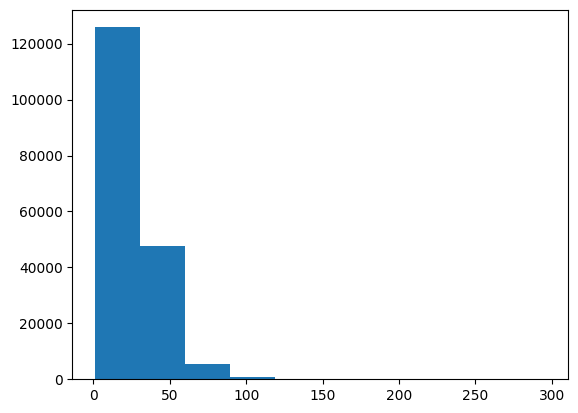

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_len)

In [ ]:
# lets check what length of words covers 95% of the sentences data
output_seq_len = np.percentile(sent_len,95)
output_seq_len

55.0

TEXT VECTORIZER LAYER (This layer turns our words from text to numbers)

In [ ]:
#how many words are in our vocab
max_tokens = 68000


In [ ]:

# Create text vectorizer

# After TensorFlow 2.6
from tensorflow.keras.layers import TextVectorization

# Before TensorFlow 2.6
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences



# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")


# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

# Get the config of our text vectorizer
text_vectorizer.get_config()

ModuleNotFoundError: No module named 'tensorflow.keras.layers.preprocessing'

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding")

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")


In [ ]:

# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

In [ ]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get summary of Conv1D model
model_1.summary()

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

In [ ]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

In [ ]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_pred
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results